In [98]:
import jax
import jax.numpy as jnp
import flax
from flax import nnx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from functools import partial

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{type1cm}'

# Quantized activation functions with Straight through estimators

- Goal of this notebook is to put togeter the following quantized activation functions. Here is an intended list:
1. ReLU
2. Double rectified ReLU
3. Sigmoid



## ReLU

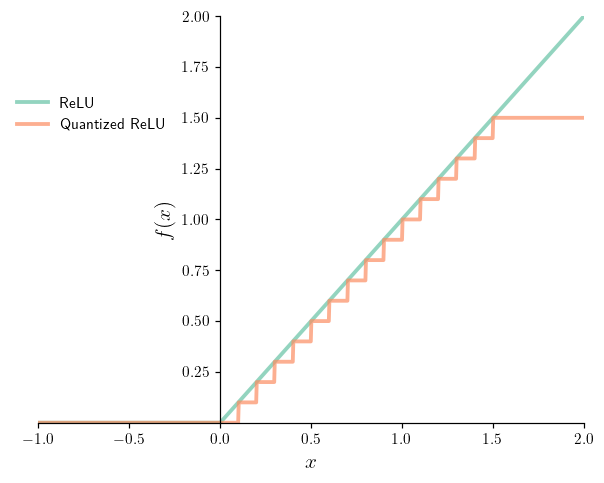

In [100]:
def quantized_relu(
    x: float, # input value, set up uses vmap
    bits: int = 4,
    max_value: float = 1.0,
):

    """
    Quantized relu function.
    Args:
        x: input value
        bits: number of bits for quantization
        max_value: maximum value for quantization
    
    Returns:
        Quantized value of x
    """

    # find the levels
    num_levels = 2**bits - 1

    # find the threshold
    thresholds = jnp.linspace(0, max_value, num_levels + 1)

    # find the corresponding mappings
    levels = nnx.relu(thresholds)

    # determine all indices where the thresholds are less than x
    less_than = levels < x

    # find the index of the largest threshold that is less than x
    idx = jnp.sum(less_than) - 1
    idx = jnp.clip(idx, 0, len(thresholds)-1)

    out = levels[idx]

    return out



# testing the quantized relu function
x_test = jnp.linspace(-1., 2., 1000)
x_relu = nnx.relu(x_test)
x_qrelu = jax.vmap(quantized_relu, in_axes=(0, None, None))(x_test, 4, 1.5)

# plotting 
fig, ax = plt.subplots(dpi = 110)
set10_pal = sns.color_palette("Set2", 10)
ax.plot(x_test, x_relu, label=r"ReLU", c=set10_pal[0], lw=2.5, alpha=.7)
ax.plot(x_test, x_qrelu, label=r"Quantized ReLU", c=set10_pal[1], lw=2.5, alpha=.7)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$f(x)$", fontsize=14)
ax.legend(frameon=False, loc=(-0.05, 0.7))
ax.set_yticks(jnp.linspace(0.25, 2.0, 8))

ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 2.0)

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

sns.despine()


In [101]:
# define backward pass for quantized relu
# treat it as if it were a relu
# @partial(jax.custom_vjp, nondiff_argnums=(1, 2))
def straight_through_quantized_relu(
    x: float, #input value,
    bits: int = 4,
    max_value: float = 1.0
):

    """
    Straight through estimator for quantized relu.
    """

    zero = x - jax.lax.stop_gradient(x)
    grad = zero + jax.lax.stop_gradient(quantized_relu(x, bits, max_value))

    return grad

# testing
print(f"q_relu(x) = {quantized_relu(0.5)}")
print(f"straight through forward = {straight_through_quantized_relu(0.5)}")

print(f"auto grad of q_relu = {jax.grad(quantized_relu)(0.5)}")
print(f"using STE = {jax.grad(straight_through_quantized_relu)(0.5)}")

q_relu(x) = 0.46666669845581055
straight through forward = 0.46666669845581055
auto grad of q_relu = 0.0
using STE = 1.0


In [107]:
# using custom_vjp

@partial(jax.custom_vjp, nondiff_argnums=(1, 2))
def quantized_relu_ste(
    x: float,
    bits: int = 8,
    max_value: float = 2.0,
    **kwargs
):

    return quantized_relu(x, bits, max_value)

def quantized_relu_fwd(
    x: float,
    bits: int = 8,
    max_value: float = 2.0,
    **kwargs
):

    primal_out = quantized_relu(x, bits, max_value)
    return primal_out, x

def quantized_relu_bwd(
    bits, max_value, residuals, gradients
):
    x = residuals
    grad = jnp.where(x > 0, 1.0, 0.0)

    return (grad*gradients, )

quantized_relu_ste.defvjp(quantized_relu_fwd, quantized_relu_bwd)

In [ ]:
# testing
key = jax.random.key(1435)
x_test = jax.random.normal(key, (5, 10))

print(f"Test input = {x_test}")

# forward pass
x_test_shape = x_test.shape
y = jax.vmap(quantized_relu_ste, in_axes=(0, None, None))(x_test.flatten(), 8, 2.0)

print(f"Outs = {y}")


Test input = [[ 0.26492587  1.1237456   0.2940835   0.6650775   0.84790945  0.2143917
   0.06733563 -0.7074875  -0.1938227   0.3873634 ]
 [-0.50155795 -0.8824733   1.5763451  -0.15191355 -0.9742329  -0.08459407
  -1.9711989  -0.23225829  0.81321216  0.9419283 ]
 [ 0.8358773  -1.4805877  -2.2777958   0.27622217  0.8526375  -1.3873721
   1.6078974   0.3510882  -1.9227772   1.8008469 ]
 [ 1.1072831   1.2593466   0.12804882  0.76791936 -0.34087273  1.2219316
   1.0426373  -0.36649597 -2.1325328  -1.361489  ]
 [-1.5313423  -0.9063598   1.5172201  -0.87163955 -0.8793821  -0.18170193
  -0.65821224  0.7451525  -1.8369389   0.18719244]]
Outs = [0.25882354 1.1215687  0.2901961  0.65882355 0.8470589  0.21176472
 0.0627451  0.         0.         0.38431376 0.         0.
 1.5686276  0.         0.         0.         0.         0.
 0.8078432  0.94117653 0.8313726  0.         0.         0.27450982
 0.8470589  0.         1.6078433  0.34509805 0.         1.7960786
 1.1058824  1.254902   0.1254902  0.760